In [1]:
import time
import glob
import copy
import re
import csv
import zlib
import scipy as sp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.animation as animation
import matplotlib.ticker as ticker
from IPython.display import display,clear_output,HTML
from lmfit import Model

import seaborn as sns
from decimal import Decimal
#import rebound

# Data read-in

In [2]:
folderpath = '4.5e9_1000_Rcrit3_NoOverlapChem' #The format should always be 'timescale_#ofcomets(notnecessarilycorrect)_criticalradiusorIAS15_chemdistribution'
migration = 'UNMigrate' #'NoMigrate'
n_comets = 10
plot_observed_comets = "off"

In [3]:
#Get relevant meta-data from folderpath name
meta = re.search('4.5e9_(.*)_(.*)_(.*)', folderpath)
ChemDist,Rcrit = meta.group(3),meta.group(2)
print(ChemDist,Rcrit)

NoOverlapChem Rcrit3


In [4]:
#Give each comet a name (unique sequence of numbers) based on comet number and file number (optional)
def generate_comet_name(comet_number, migration_file_number):
    return zlib.adler32("{:d}{:d}{:d}{:d}".format(comet_number, migration_file_number, comet_number*migration_file_number, comet_number+migration_file_number).encode('utf-8')) & 0xffffffff

In [5]:
def read_migration_data(filename, snapshot_num):
    #print(filename)
    t_list, snapshot_rows = [], []
    migration_file_num = int(filename.split("_")[-1].replace(".csv", ""))
    with open(filename, 'r') as fle:
        i = 0
        for line in fle:
            if ("Load error" in line):
                fle.readline()
                break
            else:
                break
        fle.readline()
        while (i < snapshot_num):
            fle.readline()
            while (fle.readline().rstrip() != ""):
                continue
            else:
                i = i + 1
        while (len(snapshot_rows) == 0 or snapshot_rows[-1].rstrip() != ""):
            snapshot_rows.append(fle.readline())
        snapshot_rows.pop()
        snapshot_rows = [i.rstrip().split(",") for i in snapshot_rows]

        #Give each comet a name (unique sequence of numbers) based on comet number and file number (optional)
        #snapshot_rows = [{generate_comet_name(int(i[0].split("_")[-1]), migration_file_num): np.array(i[1:], dtype=np.float64)} for i in snapshot_rows if i[0] in ["Comet_*"]]
        
        #Convert to dataframe with temporary headings
        if ("LinearChem" in ChemDist):
            snapshot_df = pd.DataFrame(snapshot_rows,columns=["1","2","3","4"])
        elif ("BinaryChem" in ChemDist or "NoOverlapChem" in ChemDist):
            snapshot_df = pd.DataFrame(snapshot_rows,columns=["1","2","3","4","5"])

        def label_chemdist(row):
            try:
                if row["CO"] + row["CO2"] > 1.:
                    return "Both"
                if row["CO"] == 1:
                    return "CO"
                if row["CO2"] == 1:
                    return "CO2"
                return "None"
            except:
                return "None"

        #Clean dataframe
        #snapshot_df = snapshot_df.dropna(axis=0,how="any")
        snapshot_df["Object"] = snapshot_df.iloc[:,0]
        snapshot_df["a"] = pd.to_numeric(snapshot_df.iloc[:,1])
        snapshot_df["e"] = pd.to_numeric(snapshot_df.iloc[:,2])
        if ("BinaryChem" in ChemDist) or ("NoOverlapChem" in ChemDist):
            snapshot_df["CO"] = pd.to_numeric(snapshot_df.iloc[:,3],errors='coerce')
            snapshot_df["CO2"] = pd.to_numeric(snapshot_df.iloc[:,4],errors='coerce')
            snapshot_df["ChemDist"] = snapshot_df.apply(lambda row:label_chemdist(row),axis=1)
            snapshot_df = snapshot_df.drop(snapshot_df.columns[:-6], axis=1)
        elif ("LinearChem" in ChemDist):
            snapshot_df["Chem_ratio"] = pd.to_numeric(snapshot_df.iloc[:,3],errors='coerce')
            snapshot_df = snapshot_df.drop(snapshot_df.columns[:-4], axis=1)

    return snapshot_df

## Clean data

In [6]:
#Data read-in
orbits_data, planets_orbits_data = [], []

try:
    #Try reading processed single data file, clean data if it doesn't exist
    with open('./Cluster_Output/'+folderpath+'/'+folderpath+'.csv', 'r') as fle1:
        t_list = [float(i) for i in fle1.readline().split(",")]
    df = pd.read_csv('./Cluster_Output/'+folderpath+'/'+folderpath+'.csv', skiprows=[0,1], skip_blank_lines=False)
    df_list = np.split(df, df[df.isnull().all(1)].index)
    for snapshot_df_conc in df_list:
        snapshot_df_conc = snapshot_df_conc.dropna(how="any",axis=0)
        if snapshot_df_conc.empty:
            pass
        else:
            orbits_data.append(snapshot_df_conc)
            
    with open('./Cluster_Output/'+folderpath+'/'+folderpath+'_Planets.csv', 'r') as fle2:
        t_list = [float(i) for i in fle2.readline().split(",")]
    df_p = pd.read_csv('./Cluster_Output/'+folderpath+'/'+folderpath+'_Planets.csv', skiprows=[0,1], skip_blank_lines=False)
    df_p_list = np.split(df_p, df_p[df_p.isnull().all(1)].index)
    for snapshot_df_p_conc in df_p_list:
        snapshot_df_p_conc = snapshot_df_p_conc.dropna(how="all",axis=0)
        if snapshot_df_p_conc.empty:
            pass
        else:
            planets_orbits_data.append(snapshot_df_p_conc)
            

except FileNotFoundError:
    #Take the list of snapshot times, required for time plots
    with open(glob.glob('./Cluster_Output/'+folderpath+'/'+migration+'*.csv')[0]) as fle:
        for line in fle:
            if ("Load error" in line):
                pass
            else:
                t_list = [float(i) for i in line.replace("[", "").replace("]", "").split(",")]
                break
        with open('./Cluster_Output/'+folderpath+'/'+folderpath+'.csv', 'w') as csvfile1, open('./Cluster_Output/'+folderpath+'/'+folderpath+'_Planets.csv', 'w') as csvfile2:
        #with open('./Cluster_Output/'+folderpath+'/'+folderpath+'_Planets.csv', 'w') as csvfile2:
            output_writer1, output_writer2 = csv.writer(csvfile1, delimiter=','), csv.writer(csvfile2, delimiter=',') 
            output_writer1.writerow(t_list)
            output_writer1.writerow("")
            #output_writer2 = csv.writer(csvfile2, delimiter=',')
            output_writer2.writerow(t_list)
            output_writer2.writerow("")

    #print(t_list)

    t1 = time.time()
    #with open('./Cluster_Output/'+folderpath+'/'+folderpath+'_Planets.csv', 'a') as csvfile2:
    with open('./Cluster_Output/'+folderpath+'/'+folderpath+'.csv', 'a') as csvfile1, open('./Cluster_Output/'+folderpath+'/'+folderpath+'_Planets.csv', 'a') as csvfile2:
        for i in range(len(t_list)):
            snapshot_df_list = []
            for filename in glob.glob('./Cluster_Output/'+folderpath+'/'+migration+'*.csv'): 
                snapshot_df = read_migration_data(filename, i)
                snapshot_df_list.append(snapshot_df)
                del snapshot_df
                #print(t_list)
            snapshot_df_conc = pd.concat(snapshot_df_list)
            del snapshot_df_list

            #Get separate dataframes for planets, drop all comet rows for this dataframe
            snapshot_df_p_conc = snapshot_df_conc[~snapshot_df_conc["Object"].str.startswith('Comet')]
            #print(snapshot_df_p_conc)
            
            #Delete rows that have any NaNs
            snapshot_df_conc = snapshot_df_conc.dropna(axis=0,how="any")

            #Write to single csv file for ease of access
            if i == 0:
                snapshot_df_conc.to_csv(csvfile1, header=True, index=False)
                snapshot_df_p_conc.to_csv(csvfile2, header=True, index=False)
            else:
                snapshot_df_conc.to_csv(csvfile1, header=False, index=False)
                snapshot_df_p_conc.to_csv(csvfile2, header=False, index=False)
                
            output_writer1, output_writer2 = csv.writer(csvfile1, delimiter=','), csv.writer(csvfile2, delimiter=',')
            #output_writer2 = csv.writer(csvfile2, delimiter=',')
            output_writer1.writerow("")
            output_writer2.writerow("")

            orbits_data.append(snapshot_df_conc)
            planets_orbits_data.append(snapshot_df_p_conc)
            
            del snapshot_df_conc, snapshot_df_p_conc

            print("\r",i/len(t_list)*100,"percent complete", end="")
            clear_output(wait=True)
    t2 = time.time()
    print("Time elapsed (minutes):",(t2-t1)/60)

# Plotting Functions

In [7]:
#Histogram (semi-major axis) plot function
def plot_a_hist(orbits, sim_num, timescale, Rcrit, ChemDist):
    fig, ax = plt.subplots(figsize=(16,8))
    binwidth = 1
    plt.hist(orbits, bins=np.arange(0., 2000. + binwidth, binwidth))
    plt.title("Final semi-major axes of comets, "+str(sim_num)+", t_max = "+timescale+" yrs, "+Rcrit+" "+ChemDist,fontsize=18)
    plt.xlabel("Orbit Distance (AU)",fontsize=16)
    plt.ylabel("Frequency",fontsize=16)
    plt.tick_params(axis='both', which='major', labelsize=16)
    plt.grid()
    plt.savefig("Semi-major Axis Frequency, "+sim_num+", t_max = "+timescale+" yrs, "+Rcrit+" "+ChemDist+".png", bbox_inches='tight', format='png')

In [8]:
#Histogram (eccentricity) plot function
def plot_e_hist(orbits, sim_num, timescale, Rcrit, ChemDist):
    fig, ax = plt.subplots(figsize=(16,8))
    binwidth = 0.01
    plt.hist(orbits, bins=np.arange(0, 1 + binwidth, binwidth))
    plt.title("Final eccentricities of comets, "+str(sim_num)+", t_max = "+timescale+" yrs, "+Rcrit+" "+ChemDist,fontsize=18)
    plt.xlabel("Eccentricity",fontsize=16)
    plt.ylabel("Frequency",fontsize=16)
    plt.tick_params(axis='both', which='major', labelsize=16)
    plt.grid()
    plt.savefig("Eccentricity Frequency, "+sim_num+", t_max = "+timescale+" yrs, "+Rcrit+" "+ChemDist+".png", bbox_inches='tight', format='png')

In [9]:
#Plot final semi-major axis vs. eccentricity
def plot_a_e(df_list, df_obs, sim_num, timescale, Rcrit, ChemDist):
    sns.set(style="ticks")
    
    if ("BinaryChem" in ChemDist):
        fig, ax = plt.subplots(figsize=(16,8))
        scatters = []
        groups = df_list[-1].groupby("ChemDist")
        for name, group in groups:
            scat = ax.scatter(group.a, group.e, data=df_list[-1], marker='o', label=name, sizes=[8])
            scatters.append(scat)
        
        if plot_observed_comets == "on":
            groups2 = df_obs.groupby("Chem_obs")
            for name2, group2 in groups2:
                ax.plot(group2.a_obs, group2.e_obs, marker='*', linestyle='', ms=16, label=name2)
        else:
            pass

        ax.legend()
        #fg = sns.FacetGrid(data=df, hue="ChemDist", hue_order=["None","CO2","CO","Both"], size=7, aspect=2)
        #fg.map(plt.scatter, "a", "e", s=8).add_legend()
        
    elif ("NoOverlapChem" in ChemDist):
        fig, ax = plt.subplots(figsize=(16,8))
        scatters = []
        groups = df_list[-1].groupby("ChemDist")
        for name, group in groups:
            scat = ax.scatter(group.a, group.e, data=df_list[-1], marker='o', label=name, sizes=[8])
            scatters.append(scat)

        '''if plot_observed_comets == "on":
            scat2 = plt.scatter(df_obs["a_obs"], df_obs["e_obs"],
                         c=df_obs["Chem_obs"].apply(lambda x: colors[x]), s=256, marker="*")
            rp2 = sns.regplot("a_obs", "e_obs", data=df_obs, scatter=False, fit_reg=False,color=".1")
        else:
            pass'''

        ax.legend()
        
    elif ("LinearChem" in ChemDist):        
        fig, ax = plt.subplots(figsize=(16,8))
        scat = plt.scatter(df_list[-1]["a"], df_list[-1]["e"], c=df_list[-1]["Chem_ratio"], s=6, cmap="viridis")
        
        '''if plot_observed_comets == "on":
            scat2 = plt.scatter(df_obs["a_obs"], df_obs["e_obs"],
                         c=df_obs["Chem_ratio_obs"], s=256, cmap="viridis", marker="*")
            rp2 = sns.regplot("a_obs", "e_obs", data=df_obs, scatter=False, fit_reg=False,color=".1")
        else:
            pass'''
        
        rp = sns.regplot("a", "e", data=df_list[-1], scatter=False, fit_reg=False,color=".1")
        cbar = plt.colorbar(scat)
        cbar.ax.set_ylabel("CO/CO2 Ratio", rotation=270)

    if max(df_list[-1]["a"]) > 50.:
        plt.xlim([0,400.])
    if max(df_list[-1]["e"]) > 1.:
        plt.ylim([0,1.])
        
    plt.xlabel("Semi-major axis (AU)", fontsize=16)
    plt.ylabel("Eccentricity", fontsize=16)
    plt.tick_params(axis='both', which='major', labelsize=16)
    plt.title("Semi-major Axis vs. Eccentricity, "+sim_num+", t_max = "+timescale+" yrs, "+Rcrit+" "+ChemDist,
             fontsize=18)
    plt.grid()
    plt.savefig("Semi-major Axis vs. Eccentricity, "+sim_num+", t_max = "+timescale+" yrs, "+Rcrit+" "+ChemDist+".png", 
                bbox_inches="tight", format="png")

In [10]:
#Animate semi-major axis vs. eccentricity over time
def anim_a_e(df_list, df_obs, sim_num, timescale, t_list, Rcrit, ChemDist):
    sns.set(style="ticks")
    
    if ("BinaryChem" in ChemDist):
        fig, ax = plt.subplots(figsize=(16,8))
        scatters = []
        labels = df_list[0]["ChemDist"]
        groups = df_list[0].groupby("ChemDist")
        for name, group in groups:
            scat = ax.scatter(group.a, group.e, data=df_list[0], marker='o', label=name, sizes=[8])
            scatters.append(scat)
        
        if plot_observed_comets == "on":
            scat2 = plt.scatter(df_obs["a_obs"], df_obs["e_obs"],
                         c=df_obs["Chem_obs"].apply(lambda x: colors[x]), s=256, marker="*")
            rp2 = sns.regplot("a_obs", "e_obs", data=df_obs, scatter=False, fit_reg=False,color=".1")
        else:
            pass

        ax.legend()
        
    elif ("NoOverlapChem" in ChemDist):
        fig, ax = plt.subplots(figsize=(16,8))
        scatters = []
        labels = df_list[0]["ChemDist"]
        groups = df_list[0].groupby("ChemDist")
        for name, group in groups:
            scat = ax.scatter(group.a, group.e, data=df_list[0], marker='o', label=name, sizes=[8])
            scatters.append(scat)
            
        '''if plot_observed_comets == "on":
            scat2 = plt.scatter(df_obs["a_obs"], df_obs["e_obs"],
                         c=df_obs["Chem_obs"].apply(lambda x: colors[x]), s=256, marker="*")
            rp2 = sns.regplot("a_obs", "e_obs", data=df_obs, scatter=False, fit_reg=False,color=".1")
        else:
            pass'''

        ax.legend()
        
    elif ("LinearChem" in ChemDist):        
        fig, ax = plt.subplots(figsize=(16,8))
        scat = plt.scatter(df_list[0]["a"], df_list[0]["e"], c=df_list[0]["Chem_ratio"], s=4, cmap="viridis")
        
        rp = sns.regplot("a", "e", data=df_list[0], scatter=False, fit_reg=False,color=".1")
        cbar = plt.colorbar(scat)
        cbar.ax.set_ylabel("CO/CO2 Ratio", rotation=270)

    time_text = ax.text(0.75, 0.05,'',horizontalalignment='left',verticalalignment='top', transform=ax.transAxes)

    def update(frame_number):
        if ("NoOverlapChem" in ChemDist) or ("BinaryChem" in ChemDist):
            #print(t_list.index(frame_number))
            groups = df_list[t_list.index(frame_number)].groupby("ChemDist")
            for i, (name, group) in enumerate(groups):
                a_list, e_list = np.array(group.a), np.array(group.e)
                a_e = np.column_stack((a_list,e_list))
                scatters[i].set_offsets(a_e)
        elif ("LinearChem" in ChemDist):
            a_list, e_list = np.array(df_list[t_list.index(frame_number)]["a"]), np.array(df_list[t_list.index(frame_number)]["e"])
            a_e = np.column_stack((a_list,e_list))
            scat.set_offsets(a_e)
        time_text.set_text('Time = %.5E years' % Decimal(frame_number))
        return scat, time_text

    if max(df_list[-1]["a"]) > 50.:
        plt.xlim([0,400.])
    plt.ylim([0,1.])
    plt.xlabel("Semi-major axis (AU)", fontsize=16)
    plt.ylabel("Eccentricity", fontsize=16)
    plt.tick_params(axis='both', which='major', labelsize=16)
    plt.title("Semi-major Axis vs. Eccentricity, "+sim_num+", t_max = "+timescale+" yrs, "+Rcrit+" "+ChemDist,
             fontsize=18)
    plt.grid()
    #plt.savefig("Semi-major Axis vs. Eccentricity, "+sim_num+", t_max = "+timescale+" yrs, Rcrit = "+Rcrit+" "+ChemDist+".png", 
    #            bbox_inches="tight", format="png")
    
    #animation.embed_limit = 500
    anim = animation.FuncAnimation(fig, update, frames=t_list, interval=10)
    
    return anim

In [11]:
#Plot final semi-major axis vs. eccentricity
def plot_chem_a(df_list, df_obs, sim_num, timescale, Rcrit, ChemDist):
    sns.set(style="ticks")
    
    if ("BinaryChem" in ChemDist):
        fig, ax = plt.subplots(figsize=(16,8))
        points = sns.stripplot(df_list[-1]["ChemDist"], df_list[-1]["a"], size=4, jitter=True)
        
        if plot_observed_comets == "on":
            points2 = plt.scatter(df_obs["Chem_obs"], df_obs["a_obs"], s=256, marker="*")
        else:
            pass
        
        x_label = "Chemical Distribution"

        #fg = sns.FacetGrid(data=df, hue="ChemDist", hue_order=["None","CO2","CO","Both"], size=7, aspect=2)
        #fg.map(plt.scatter, "a", "e", s=8).add_legend()
    elif ("NoOverlapChem" in ChemDist):
        fig, ax = plt.subplots(figsize=(16,8))
        points = sns.stripplot(df_list[-1]["ChemDist"], df_list[-1]["a"], size=4, jitter=True)
        
        #if plot_observed_comets == "on":
        #    points2 = plt.scatter(df_obs["Chem_obs"], df_obs["a_obs"], s=256, marker="*")
        #else:
        #    pass
        
        x_label = "Chemical Distribution"

        #fg = sns.FacetGrid(data=df, hue="ChemDist", hue_order=["CO","CO2"], size=7, aspect=2)
        #fg.map(plt.scatter, "a", "e", s=8).add_legend()
    elif ("LinearChem" in ChemDist):
        fig, ax = plt.subplots(figsize=(16,8))
        points = sns.regplot(df_list[-1]["Chem_ratio"], df_list[-1]["a"], scatter_kws={'s':4})
        
        #if plot_observed_comets == "on":
        #    points2 = plt.scatter(df_obs["Chem_ratio_obs"], df_obs["a_obs"], s=256, marker="*")
        #else:
        #    pass
        
        x_label = "Chem Ratio (CO\CO2)"

    if max(df_list[-1]["a"]) > 50.:
        plt.ylim([0,400.])
    plt.xlabel(x_label, fontsize=16)
    plt.ylabel("Semi-major Axis (AU)", fontsize=16)
    plt.tick_params(axis='both', which='major', labelsize=16)
    plt.title(x_label+" vs. Semi-major Axis (AU), "+sim_num+", t_max = "+timescale+" yrs, "+Rcrit+" "+ChemDist,
             fontsize=18)
    plt.grid()
    
    plt.savefig(x_label+" vs. Semi-major Axis (AU), "+sim_num+", t_max = "+timescale+" yrs, "+Rcrit+" "+ChemDist+".png", 
                bbox_inches="tight", format="png")

In [12]:
#Plot final semi-major axis vs. eccentricity
def plot_chem_e(df_list, df_obs, sim_num, timescale, Rcrit, ChemDist):
    sns.set(style="ticks")
    
    if ("BinaryChem" in ChemDist):
        fig, ax = plt.subplots(figsize=(16,8))
        points = sns.stripplot(df_list[-1]["ChemDist"], df_list[-1]["e"], size=4, jitter=True)
        
        if plot_observed_comets == "on":
            points2 = plt.scatter(df_obs["Chem_obs"], df_obs["a_obs"], s=256, marker="*")
        else:
            pass
        
        x_label = "Chemical Distribution"

    elif ("NoOverlapChem" in ChemDist):
        fig, ax = plt.subplots(figsize=(16,8))
        points = sns.stripplot(df_list[-1]["ChemDist"], df_list[-1]["e"], size=4, jitter=True)
        
        #if plot_observed_comets == "on":
        #    points2 = plt.scatter(df_obs["Chem_obs"], df_obs["a_obs"], s=256, marker="*")
        #else:
        #    pass
        
        x_label = "Chemical Distribution"

    elif ("LinearChem" in ChemDist):
        fig, ax = plt.subplots(figsize=(16,8))
        points = sns.regplot(df_list[-1]["Chem_ratio"], df_list[-1]["e"], scatter_kws={'s':4})
        
        #if plot_observed_comets == "on":
        #    points2 = plt.scatter(df_obs["Chem_ratio_obs"], df_obs["e_obs"], s=256, marker="*")
        #else:
        #    pass
        
        x_label = "Chem Ratio (CO\CO2)"

    if max(df_list[-1]["e"]) > 1.:
        plt.ylim([0,1.])
    plt.xlabel(x_label, fontsize=16)
    plt.ylabel("Eccentricity", fontsize=16)
    plt.tick_params(axis='both', which='major', labelsize=16)
    plt.title(x_label+" vs. Eccentricity, "+sim_num+", t_max = "+timescale+" yrs, "+Rcrit+" "+ChemDist,
             fontsize=18)
    plt.grid()
    
    plt.savefig(x_label+" vs. Eccentricity, "+sim_num+", t_max = "+timescale+" yrs, "+Rcrit+" "+ChemDist+".png", 
                bbox_inches="tight", format="png")

In [13]:
#Number of comets over time
def plot_n_time(original_comets, timescale, Rcrit, ChemDist):
    sns.set_style("whitegrid")
   
    #fig, ax = plt.subplots(figsize=(16, 8))
    g = sns.lmplot(data=original_comets, x="Time (Years)", y="Fraction of SD", fit_reg=False, height=8, aspect=2, scatter_kws={"s": 6})
    g.ax.minorticks_on()
    g.ax.grid(True, which="both")
    plt.title("Fraction of Surviving SD vs Time, t_max = "+timescale+" yrs, "+Rcrit+" "+ChemDist,
             fontsize=18)
    plt.savefig("Fraction of Surviving SD vs Time, t_max = "+timescale+" yrs, "+Rcrit+" "+ChemDist+".png", 
            bbox_inches="tight", format="png")
    
    
    #Get log-log graph of up to 1 billion years
    index_billion = np.where(original_comets["Time (Years)"] == 1e9)[0][0]
    g = sns.lmplot(data=original_comets[0:index_billion], x="Time (Years)", y="Fraction of SD", fit_reg=False, scatter_kws={"s": 6}, height=8, aspect=2)
    g.ax.set_xscale("log")
    g.ax.set_yscale("log")
    g.ax.set_ylim(0.005, 2)
    g.ax.set_xlim(1e5, 1.5e9)
    plt.grid(True, which="both")
    plt.title("Fraction of Surviving SD vs Time up to t = 1e9 years, t_max = "+timescale+" yrs, "+Rcrit+" "+ChemDist,
             fontsize=18)
    plt.savefig("Fraction of Surviving SD vs Time up to t = 1e9 years, t_max = "+timescale+" yrs, "+Rcrit+" "+ChemDist+".png", 
                bbox_inches="tight", format="png")
    
    
    #Plot from 1 to 4 billion years
    g =sns.lmplot(data=original_comets[index_billion:], x="Time (Years)", y="Fraction of SD", fit_reg=False, scatter_kws={"s": 6}, height=8, aspect=2)
    g.ax.minorticks_on()
    g.ax.grid(True, which="both")
    plt.title("Fraction of Surviving SD vs Time from t = 1e9 years, t_max = "+timescale+" yrs, "+Rcrit+" "+ChemDist,
             fontsize=18)
    plt.savefig("Fraction of Surviving SD vs Time from t= 1e9 years, t_max = "+timescale+" yrs, "+Rcrit+" "+ChemDist+".png", 
            bbox_inches="tight", format="png")
    
    
    #Do a simple OLS fit using lmfit
    x, y = original_comets["Time (Years)"], original_comets["Number of Comets"]

    def func_powerlaw(x, a, b, c):
        return a * np.exp(-b * x) + c

    pmodel = Model(func_powerlaw)
    #[6.37160869e+02 7.61209968e-09 1.02507305e+01]
    fit_results = pmodel.fit(y, x=x, a=600, b=8e-9, c=10)

    print(fit_results.fit_report())
    
    #Plot OLS fit
    fig, ax = plt.subplots(figsize=(16,8))
    plt.plot(x, y, 'bo', markersize=2)
    plt.plot(x, fit_results.init_fit, 'k--', label="Initial fit guess")
    plt.plot(x, fit_results.best_fit, 'r-', label="Best fit")
    plt.text(0.5e9, 800, "a * np.exp(-b * x) + c \nBest fit: "+str(fit_results.best_values))
    ax.legend(loc='best')
    plt.minorticks_on()
    plt.grid(True, which="both")
    plt.title("Number of Surviving Comets vs Time, OLS Regression, t_max = "+timescale+" yrs, "+Rcrit+" "+ChemDist,
             fontsize=18)
    plt.savefig("Number of Surviving Comets vs Time, OLS Regression, t_max = "+timescale+" yrs, "+Rcrit+" "+ChemDist+".png", 
            bbox_inches="tight", format="png") 
        
    #Get residual plots of simple linear regression
    fig, ax = plt.subplots(figsize=(16, 8))
    fit_results.plot_residuals(data_kws={"markersize":2})
    plt.minorticks_on()
    plt.grid(True, which="both")
    plt.title("Number of Surviving Comets vs Time (OLS Residuals), t_max = "+timescale+" yrs, "+Rcrit+" "+ChemDist,
             fontsize=18)
    plt.savefig("Number of Surviving Comets vs Time (OLS Residuals), t_max = "+timescale+" yrs, "+Rcrit+" "+ChemDist+".png", 
            bbox_inches="tight", format="png")
    
    fig, ax = plt.subplots(figsize=(16, 8))
    fit_results.plot_residuals(data_kws={"markersize":2})
    plt.minorticks_on()
    plt.grid(True, which="both")
    ax.set_ylim(-50,50)
    plt.grid(True, which="both")
    plt.title("Number of Surviving Comets vs Time (OLS Residuals) (-50 to 50 range), t_max = "+timescale+" yrs, "+Rcrit+" "+ChemDist,
             fontsize=18)
    plt.savefig("Number of Surviving Comets vs Time (OLS Residuals) (-50 to 50 range), t_max = "+timescale+" yrs, "+Rcrit+" "+ChemDist+".png", 
            bbox_inches="tight", format="png")
    
    '''
    sns.lmplot(data=original_comets[1:], x="Log Time", y="Fraction of SD", fit_reg=True, order=linreg_order, height=8, aspect=2, scatter_kws={"s": 6})#, robust=True)
    plt.title("Number of Surviving Comets vs Log Time, t_max = "+timescale+" yrs, "+Rcrit+" "+ChemDist+", Order "+str(linreg_order)+" Linear Regression",
             fontsize=18)
    plt.savefig("Number of Surviving Comets vs Log Time, t_max = "+timescale+" yrs, "+Rcrit+" "+ChemDist+", Order "+str(linreg_order)+" Linear Regression.png", 
            bbox_inches="tight", format="png")   

    #Try scikit learn power law fit
    def func_powerlaw(x, a, b, c):
        return a * np.exp(-b * x) + c

    target_func = func_powerlaw
    X,y = original_comets["Time (Years)"],original_comets["Fraction of SD"]

    popt, pcov = curve_fit(target_func, X, y, maxfev=2000, p0=init_guess)
    print("Optimized Function:", str(popt[0])+" * e^("+str(-popt[1])+"*x)"+" + "+str(popt[2]))

    fig, ax = plt.subplots(figsize=(16, 8))
    plt.plot(X, target_func(X, *popt), '--')
    #plt.plot(X, target_func(X, *init_guess), '--')
    plt.plot(X, y, 'ro', markersize=2)
    
    #fig, ax = plt.subplots(figsize=(16, 8))
    original_comets["Fit Residuals"] = y - target_func(X, *popt)
    sns.lmplot(data=original_comets, x="Time (Years)", y="Fit Residuals", fit_reg=False, height=8, aspect=2, scatter_kws={"s": 6})'''

In [ ]:
#Planet a and e vs. time plot function
def plot_planets_time(planets_orbits_df_list, t_list, sim_num, timescale, Rcrit, ChemDist):
    colors_list = ["r","c","g","w"]
    
    #NOTE: because each sim has it's own set of planets, take mean, min and max a and e of the planets for each sim
    planets_orbits_df_list2 = []
    for i,planets_orbits_df in enumerate(planets_orbits_df_list):
        grouped_a = planets_orbits_df.groupby("Object", as_index=False)["a"].agg({"Min a":'min','Max a':'max','Mean a':'mean'})
        grouped_e = planets_orbits_df.groupby("Object", as_index=False)["e"].agg({"Min e":'min','Max e':'max','Mean e':'mean'})
        planets_grouped_df = pd.merge(grouped_a,grouped_e,on="Object")
        planets_grouped_df["Time"] = t_list[i]
        planets_orbits_df_list2.append(planets_grouped_df)
    
    del planets_orbits_df_list
    
    #Concatenate all dataframes to single frame with time column indicating time
    planets_total_df = pd.concat(planets_orbits_df_list2)
    #print(planets_total_df)
    
    del planets_orbits_df_list2
   
    ax_list = []
    for i, (label, df) in enumerate(planets_total_df.groupby("Object")):
        ax_list.append(i)
     
    ae_dict = {"a":("Mean a","Min a","Max a"),"e":("Mean e","Min e","Max e")}
    
    #Plot min, max, and mean a of planets
    def plotting(planets_total_df,ae_dict_key,title_name,left_axis_lim,right_axis_lim):
        for i, (label, df_) in enumerate(planets_total_df.groupby("Object")):
            fig, ax_list[i] = plt.subplots(figsize=(16,4))
            df = df_[np.where(df_["Time"] == left_axis_lim)[0][0]:np.where(df_["Time"] == right_axis_lim)[0][0]]
            df.plot(x="Time", y=ae_dict[ae_dict_key][0], ax=ax_list[i], label=label, c=colors_list[i])
            plt.fill_between(x="Time", y1=ae_dict[ae_dict_key][1], y2=ae_dict[ae_dict_key][2], data=df, color="b")
            ax_list[i].grid(True, which="major")
            plt.legend(loc="best")
            plt.title(label.capitalize()+" "+title_name+" vs. Time ("+str('%.3e' % left_axis_lim)+" to "
                      +str('%.3e' % right_axis_lim)+" years), "+sim_num+", t_max = "+timescale+" yrs, "+Rcrit+" "+ChemDist,
                     fontsize=18)
            plt.xlabel("Time (Years)")
            plt.ylabel(title_name)
            plt.savefig(label.capitalize()+" "+title_name+" vs. Time ("+str('%.3e' % left_axis_lim)+" to "
                        +str('%.3e' % right_axis_lim)+" years), "+sim_num+", t_max = "+timescale+" yrs, "+Rcrit+" "+ChemDist+".png",
                       bbox_inches="tight", format="png")
    
    plotting(planets_total_df,"a","Semi-Major Axis (AU)",0,2e6)
    plotting(planets_total_df,"e","Eccentricity",0,2e6)
    plotting(planets_total_df,"a","Semi-Major Axis (AU)",2e6,4.5e9)
    plotting(planets_total_df,"e","Eccentricity",2e6,4.5e9)
    plotting(planets_total_df,"a","Semi-Major Axis (AU)",1.500e9,1.505e9)
    plotting(planets_total_df,"e","Eccentricity",1.500e9,1.505e9)
    plotting(planets_total_df,"a","Semi-Major Axis (AU)",3.000e9,3.005e9)
    plotting(planets_total_df,"e","Eccentricity",3.000e9,3.005e9)

# Manual addition of observed comets and their respective volatiles

In [15]:
#Add in known comet volatile ratios from current research
Names_obs = ["1P/Halley","153P/Ikeya-Zhang","8P/Tuttle","64P/Swift-Gehrels","19P/Borrelly","103P/Hartley 2","144P/Kushida",
            "67P/Churyumov-Gerasimenko","73P/Schwassmann-Wachmann 3-C","157P/Tritton","22P/Kopff","81P/Wild 2","88P/Howell",
            "118P/Shoemaker-Levy 4","9P/Tempel 1","116P/Wild 4","C/1979 Y1 Bradfield","C/1989 X1 Austin",
            "C/1990 K1 Levy","C/1995 O1 Hale-Bopp","C/1996 B2 Hyakutake","C/1999 H1 Lee","C/1999 S4 (LINEAR)",
            "C/2000 WM1 LINEAR","C/2001 A2 LINEAR","C/2004 Q2 Machholz","C/2006 OF2 Broughton","C/2007 N3 Lulin",
            "C/2007 Q3 Siding Spring","C/2008 Q3 Garradd","C/2009 P1 Garradd"]
a_obs = [17.834,51.214,5.702,4.451,3.609,3.469,3.866,3.464,3.063,3.412,3.459,3.452,3.110,3.466,3.146,3.485,45.259,
        -1529.839,-1498.666,182.052,2272.079,2775.377,-7227.979,-2286.223,2530.530,2403.325,-3101.674,72415.000,-9454.117,
        8926.033,-1555.613]
e_obs = [0.967,0.990,0.820,0.688,0.623,0.694,0.628,0.640,0.692,0.601,0.544,0.537,0.562,0.428,0.510,0.372,0.988,
        1.000,1.001,0.995,0.999,0.999,1.000,1.000,0.999,0.999,1.001,0.999,1.000,0.999,1.000]
Chem_obs = ["Both","CO","CO","CO2","CO2","Both","Both","CO2","CO","CO2","CO2","CO2","CO2","CO2","Both","CO2","Both",
           "Both","Both","CO","CO","CO","CO","CO","CO","CO","CO2","Both","CO2","Both","Both"]

observed_orbits = pd.DataFrame({'Names_obs' : Names_obs,
                                'a_obs' : a_obs,
                                'e_obs' : e_obs,
                                'Chem_obs' : Chem_obs})
observed_orbits

,Names_obs,a_obs,e_obs,Chem_obs
0,1P/Halley,17.834,0.967,Both
1,153P/Ikeya-Zhang,51.214,0.990,CO
2,8P/Tuttle,5.702,0.820,CO
3,64P/Swift-Gehrels,4.451,0.688,CO2
4,19P/Borrelly,3.609,0.623,CO2
5,103P/Hartley 2,3.469,0.694,Both
6,144P/Kushida,3.866,0.628,Both
7,67P/Churyumov-Gerasimenko,3.464,0.640,CO2
8,73P/Schwassmann-Wachmann 3-C,3.063,0.692,CO
9,157P/Tritton,3.412,0.601,CO2


# Do analysis

In [16]:
#Total number of original comets
comets_total = len(orbits_data[0].index)
print(comets_total)

990


In [17]:
#Quickly check a snapshot
orbits_data[-1]

,Object,a,e,CO,CO2,ChemDist
8028417,Comet_95,84.570998,0.658913,0.0,1.0,CO2
8028418,Comet_98,198.265670,0.887174,0.0,1.0,CO2
8028419,Comet_103,51.953319,0.409577,0.0,1.0,CO2
8028420,Comet_106,593.461483,0.949541,0.0,1.0,CO2
8028421,Comet_107,404.377982,0.922705,0.0,1.0,CO2
8028422,Comet_108,372.760880,0.915807,0.0,1.0,CO2
8028423,Comet_109,384.372911,0.919693,0.0,1.0,CO2
8028424,Comet_110,346.659664,0.929195,0.0,1.0,CO2
8028425,Comet_112,317.729015,0.900177,0.0,1.0,CO2
8028426,Comet_40,48.023392,0.226038,0.0,1.0,CO2


In [18]:
planets_orbits_data[-1]

,Object,a,e,CO,CO2,ChemDist
1791000,uranus,19.140836,0.068082,NaN,NaN,None
1791001,neptune,30.546585,0.049578,NaN,NaN,None
1791002,uranus,19.136251,0.094734,NaN,NaN,None
1791003,neptune,30.575601,0.058994,NaN,NaN,None
1791004,uranus,19.128356,0.076566,NaN,NaN,None
1791005,neptune,30.584645,0.027024,NaN,NaN,None
1791006,uranus,19.170909,0.046986,NaN,NaN,None
1791007,neptune,30.470374,0.046636,NaN,NaN,None
1791008,uranus,19.127793,0.032007,NaN,NaN,None
1791009,neptune,30.565292,0.073232,NaN,NaN,None


In [19]:
#Get number of original comets in each snapshot to find efficiency rate

original_comets = ["Comet_"+str(i) for i in np.arange(0,n_comets)]
original_comets_total_list = []

for i in range(len(orbits_data)):
    original_comets_total = 0
    for comet in original_comets:
        original_comets_total += len(orbits_data[i][orbits_data[i]['Object'] == (comet)])
    original_comets_total_list.append(original_comets_total)

original_comets = pd.DataFrame({'Time (Years)' : t_list,
                                'Number of Comets' : original_comets_total_list})
original_comets["Log Time"] = np.log(original_comets["Time (Years)"]+1)
original_comets["Fraction of SD"] = original_comets["Number of Comets"]/max(original_comets["Number of Comets"])
original_comets

,Time (Years),Number of Comets,Log Time,Fraction of SD
0,0.000000e+00,990,0.000000,1.000000
1,5.000000e+05,975,13.122365,0.984848
2,1.000000e+06,953,13.815512,0.962626
3,1.500000e+06,927,14.220976,0.936364
4,2.000000e+06,908,14.508658,0.917172
5,2.500000e+06,877,14.731802,0.885859
6,3.000000e+06,853,14.914123,0.861616
7,3.500000e+06,836,15.068274,0.844444
8,4.000000e+06,811,15.201805,0.819192
9,4.500000e+06,796,15.319588,0.804040


# Plots

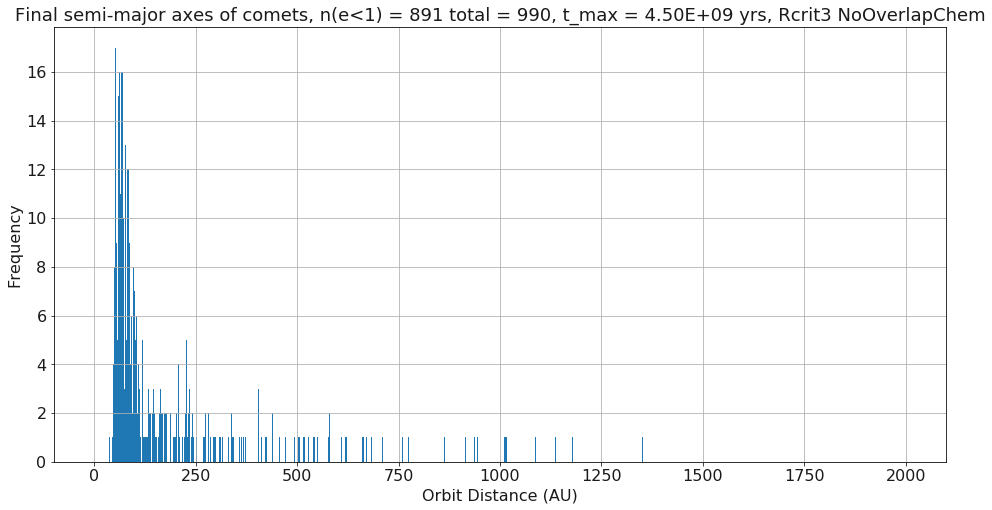

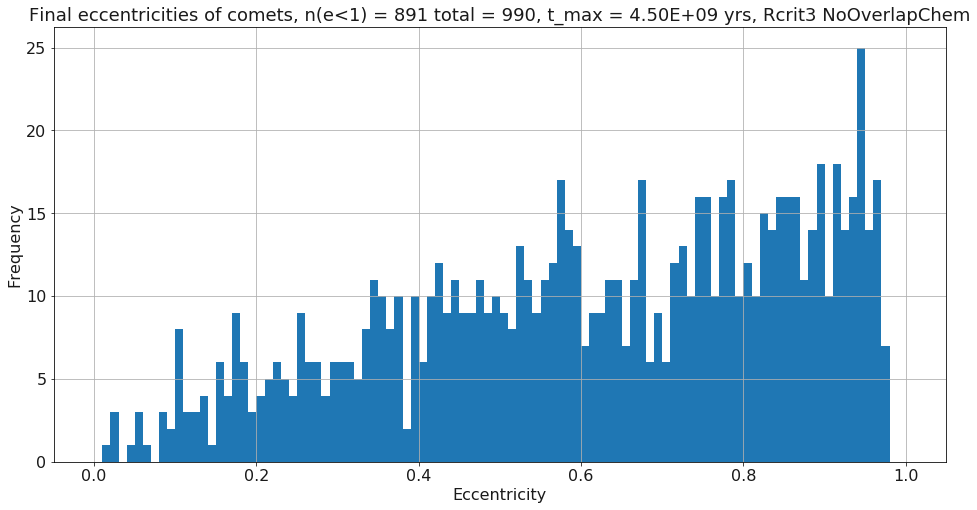

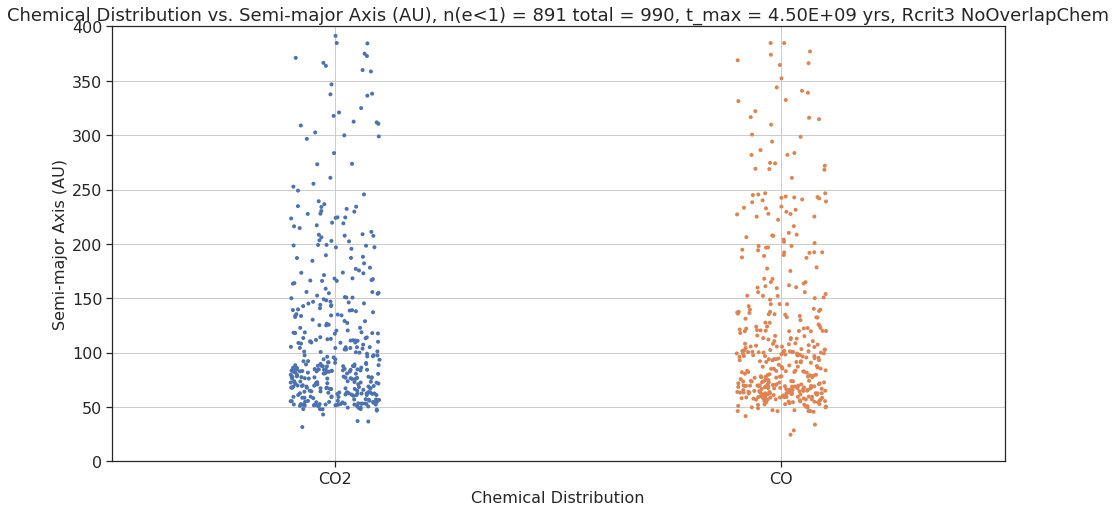

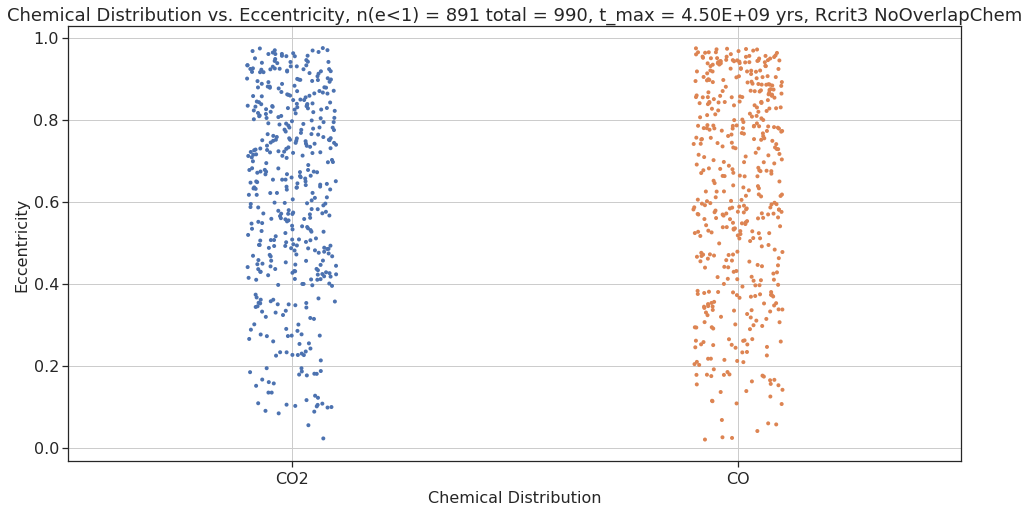

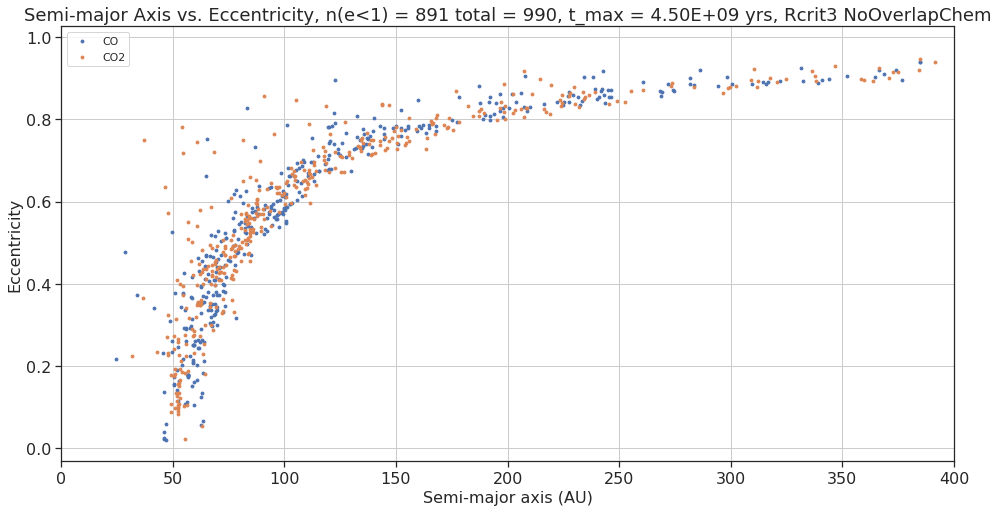

In [20]:
#Plot histograms and graph of comet semi-major axes and eccentricities (final positions)

#timescale = '%.2E' % Decimal(t_list[-1])
timescale = '%.2E' % t_list[-1]
sim_name_ = "n(e<1) = "+str((orbits_data[-1]['e'] < 1.).sum())+" total = "+str(comets_total)

def get_plots(orbits_a,orbits_e,df_list,df_obs,ChemDist,sim_name_,timescale,Rcrit):
    plot_a_hist(orbits_a,sim_name_,timescale,Rcrit,ChemDist)
    plot_e_hist(orbits_e,sim_name_,timescale,Rcrit,ChemDist)
    plot_chem_a(df_list,df_obs,sim_name_,timescale,Rcrit,ChemDist)
    plot_chem_e(df_list,df_obs,sim_name_,timescale,Rcrit,ChemDist)
    plot_a_e(df_list,df_obs,sim_name_,timescale,Rcrit,ChemDist)

get_plots(list(orbits_data[-1]["a"]),list(orbits_data[-1]["e"]),orbits_data,observed_orbits,ChemDist,
                      sim_name_,str(timescale),Rcrit)

[[Model]]
    Model(func_powerlaw)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 9001
    # variables        = 3
    chi-square         = 1637221.51
    reduced chi-square = 181.953935
    Akaike info crit   = 46841.9852
    Bayesian info crit = 46863.3005
[[Variables]]
    a:  637.163959 +/- 1.65808889 (0.26%) (init = 600)
    b:  7.6122e-09 +/- 2.8981e-11 (0.38%) (init = 8e-09)
    c:  10.2508338 +/- 0.15128457 (1.48%) (init = 10)
[[Correlations]] (unreported correlations are < 0.100)
    C(a, b) =  0.683
    C(b, c) =  0.249



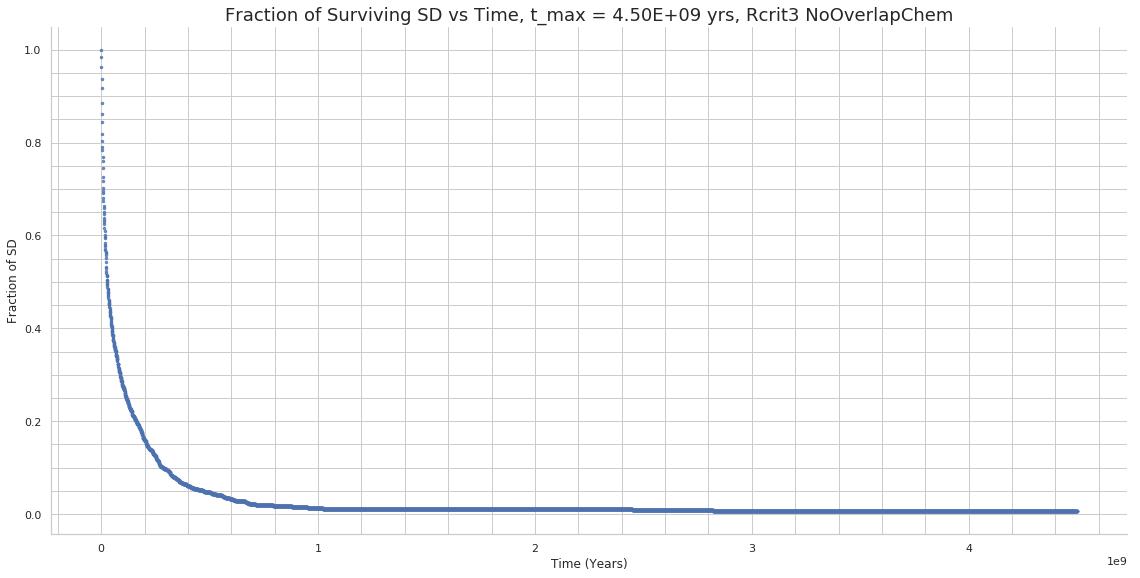

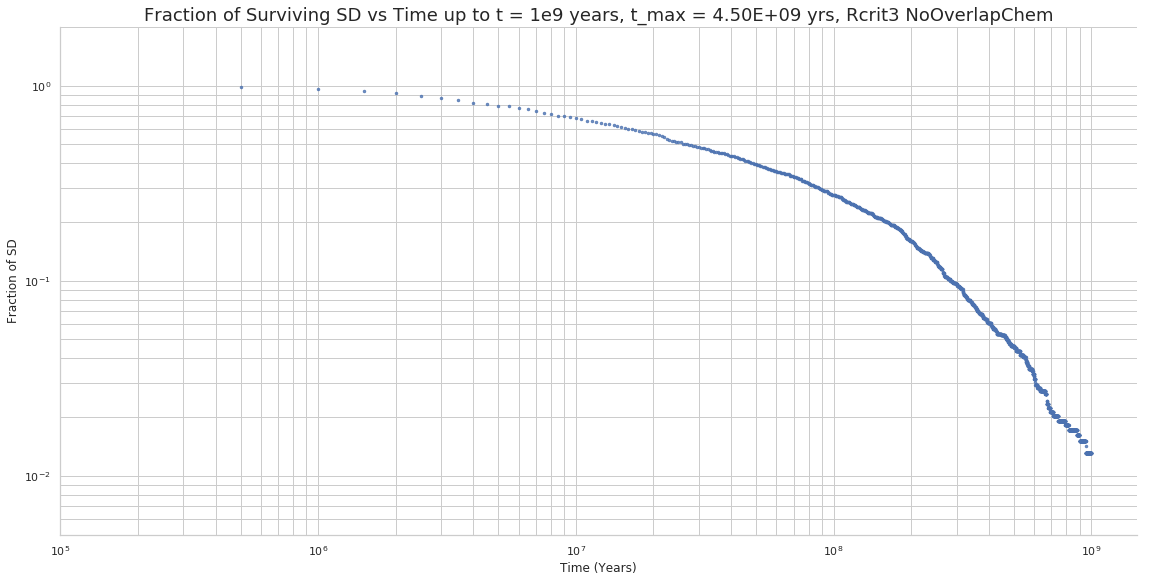

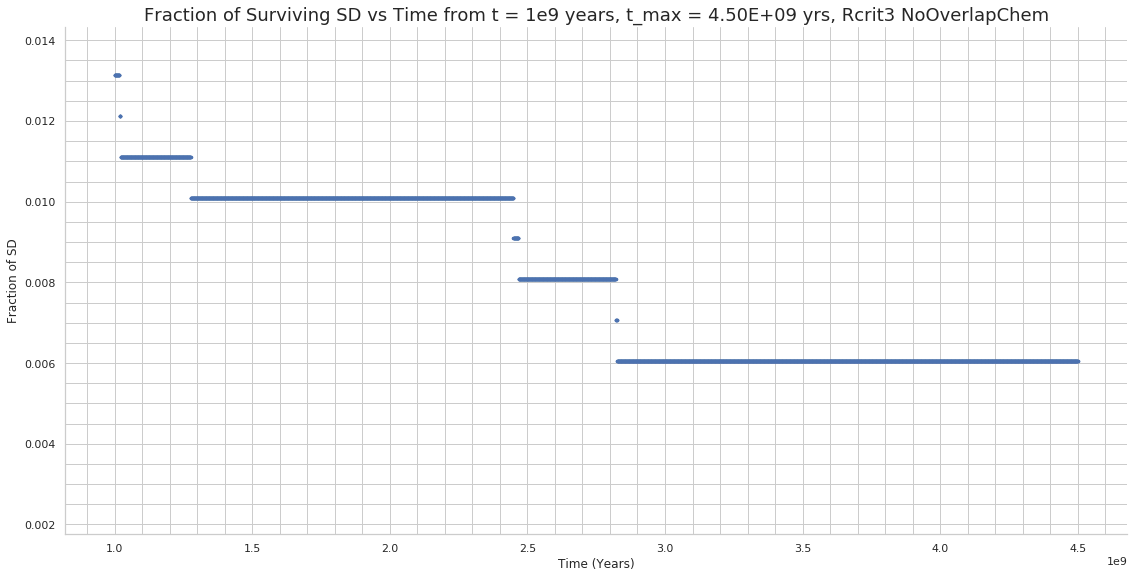

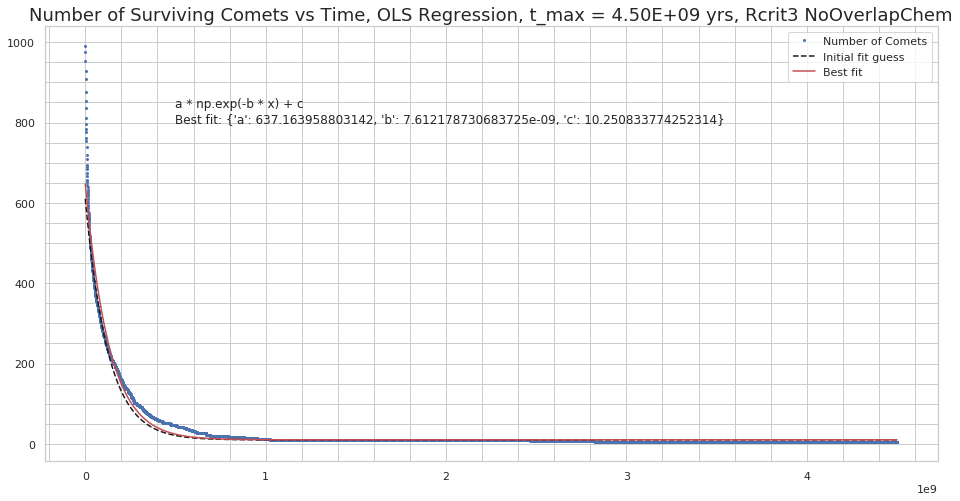

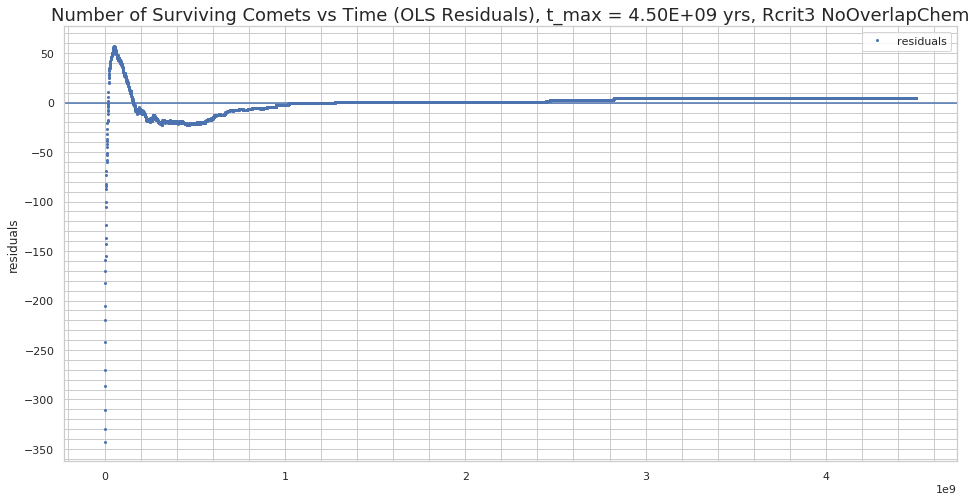

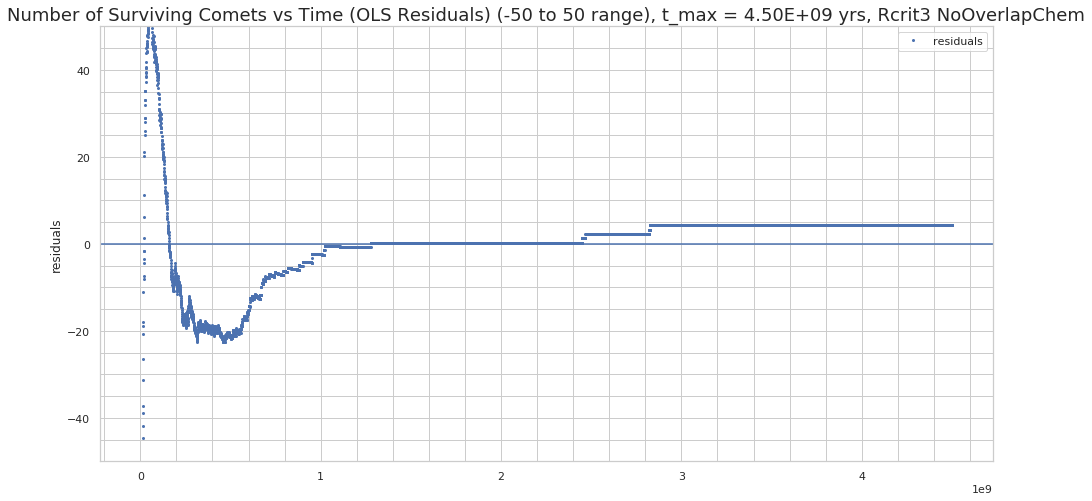

In [21]:
#[6.37160869e+02 7.61209968e-09 1.02507305e+01]
#init_guess = np.asarray([6.37160869e+02, 7.61209968e-09, 1.02507305e+01])
plot_n_time(original_comets,str(timescale),Rcrit,ChemDist)

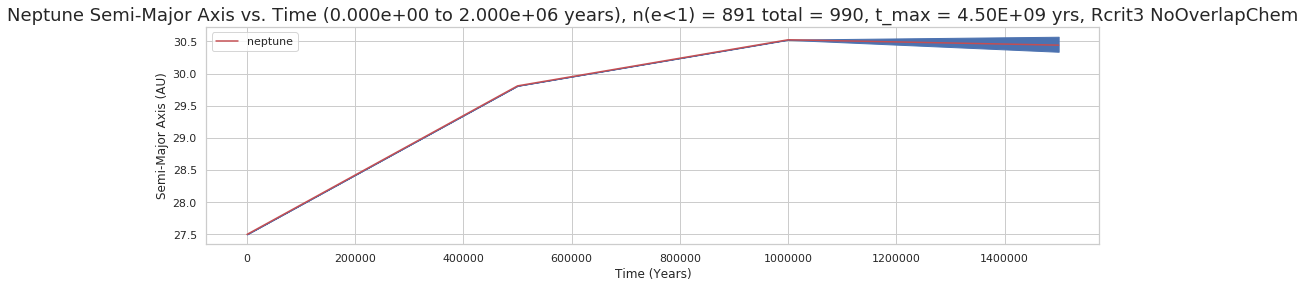

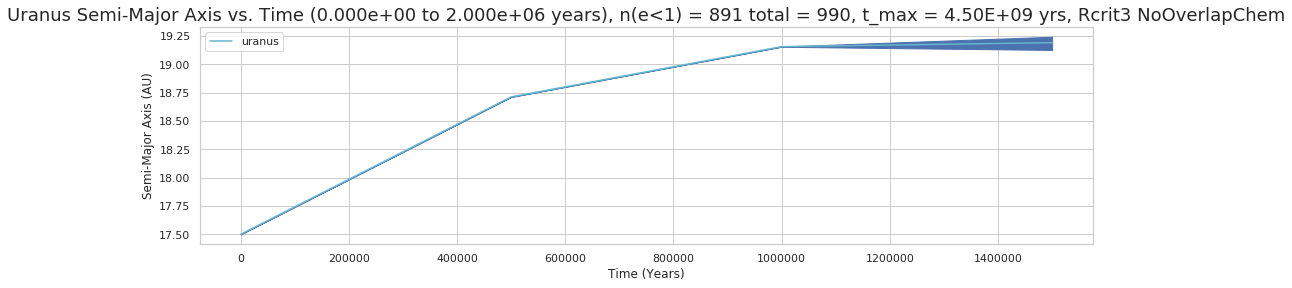

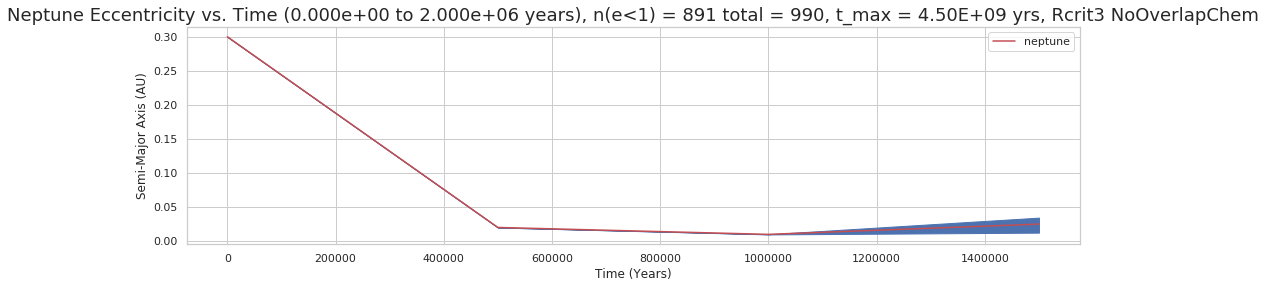

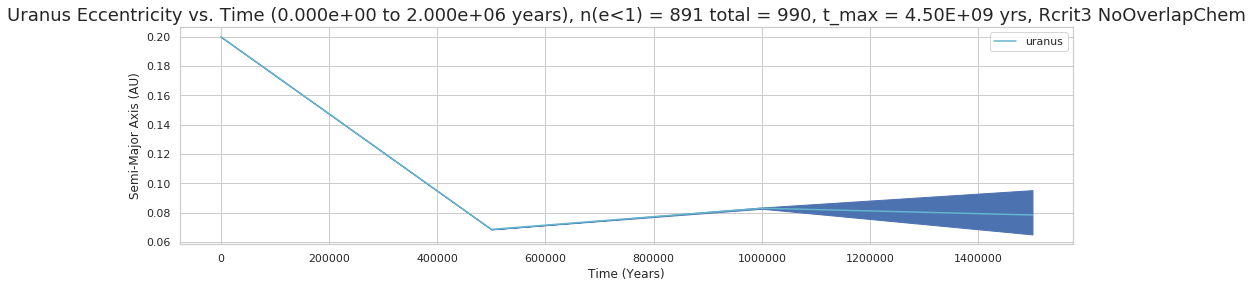

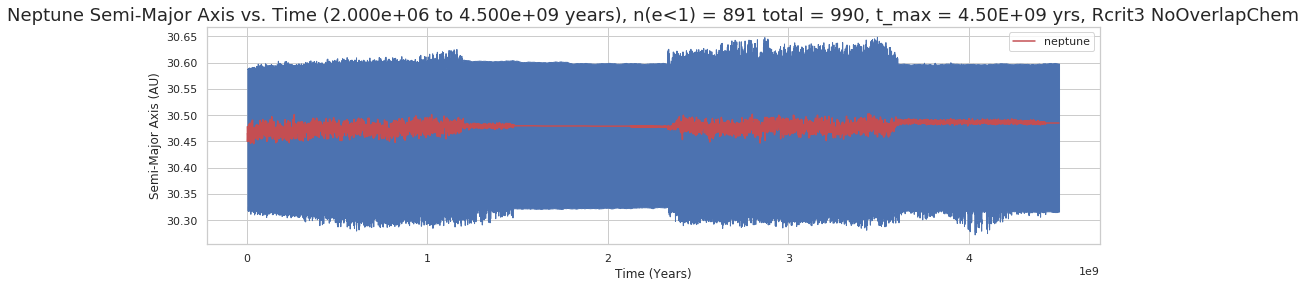

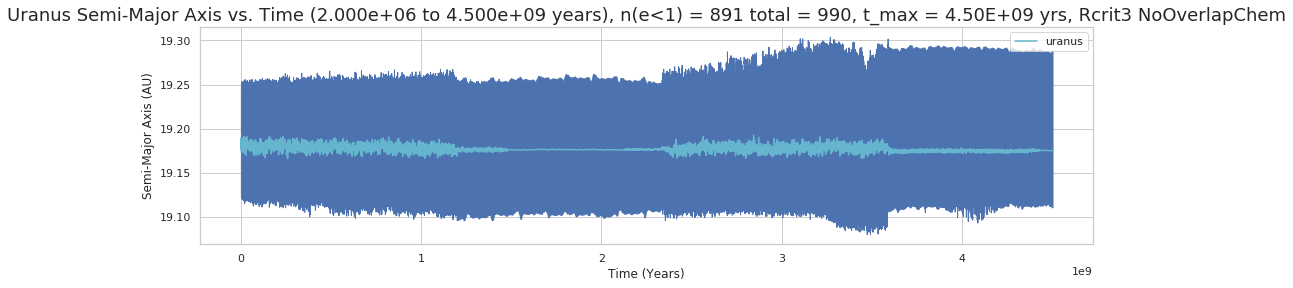

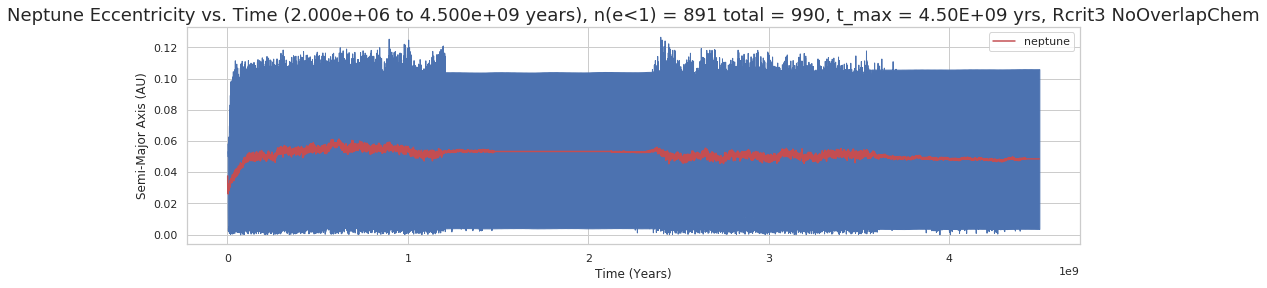

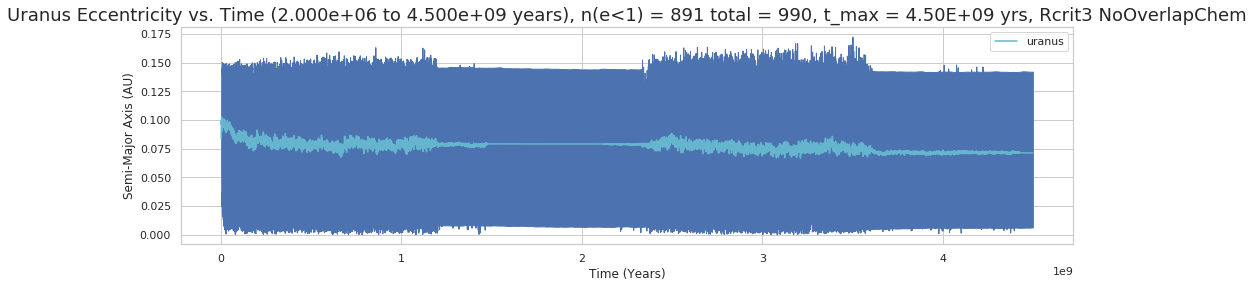

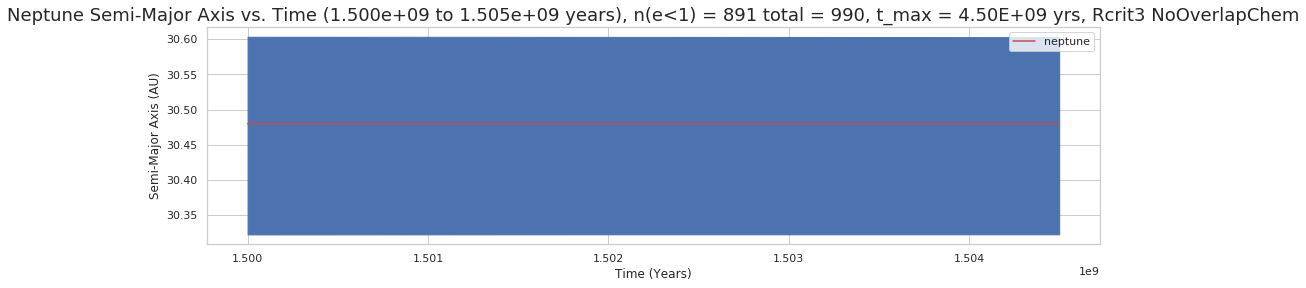

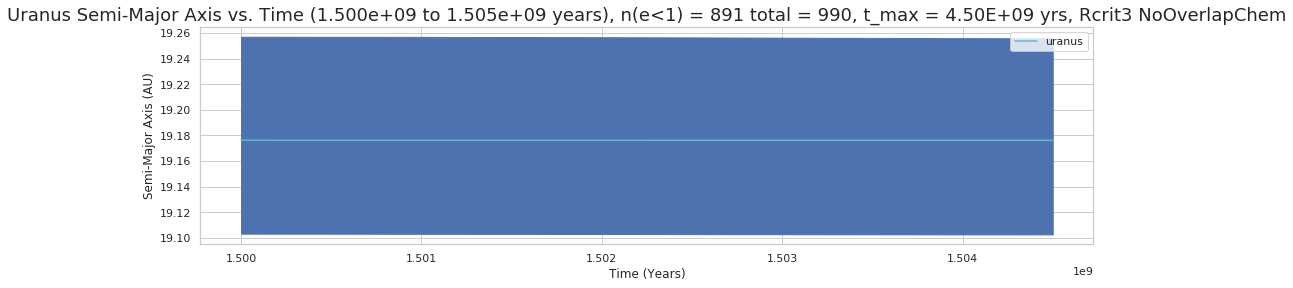

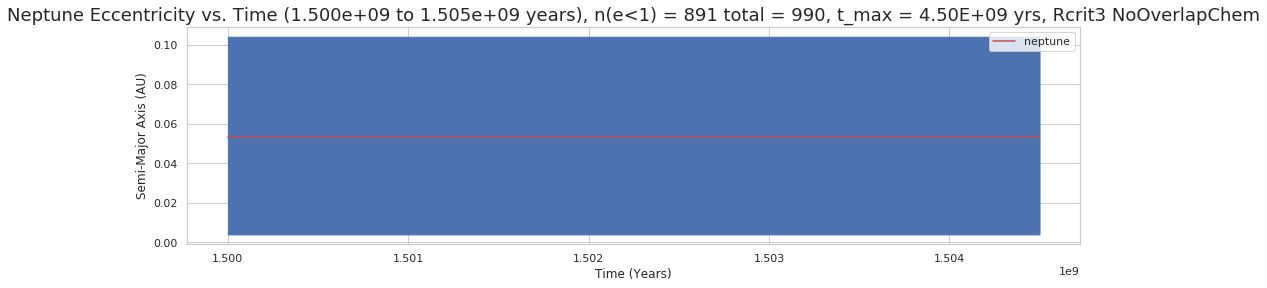

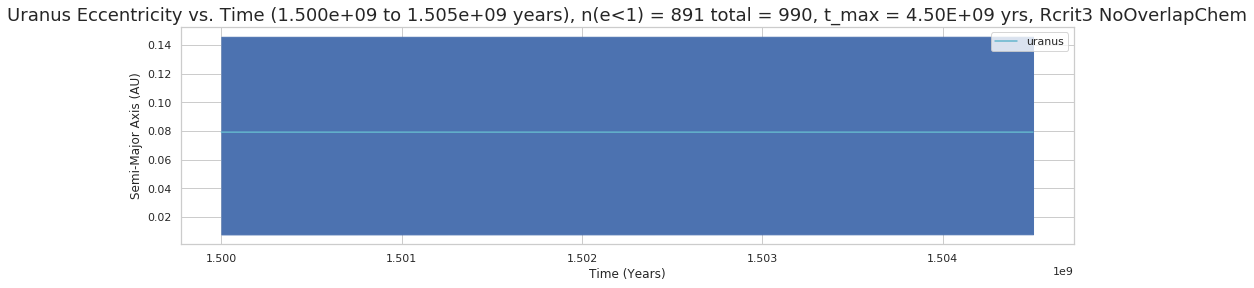

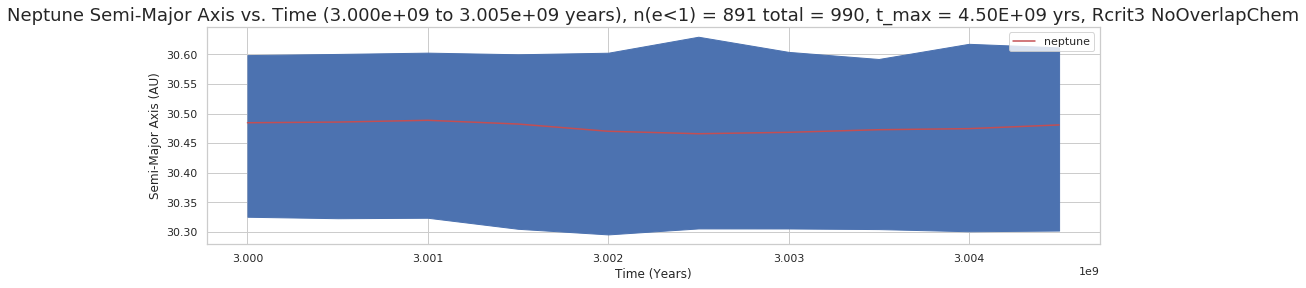

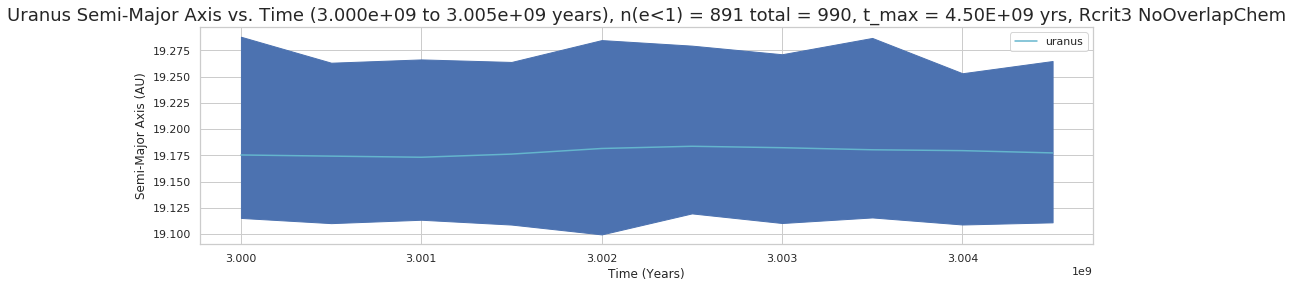

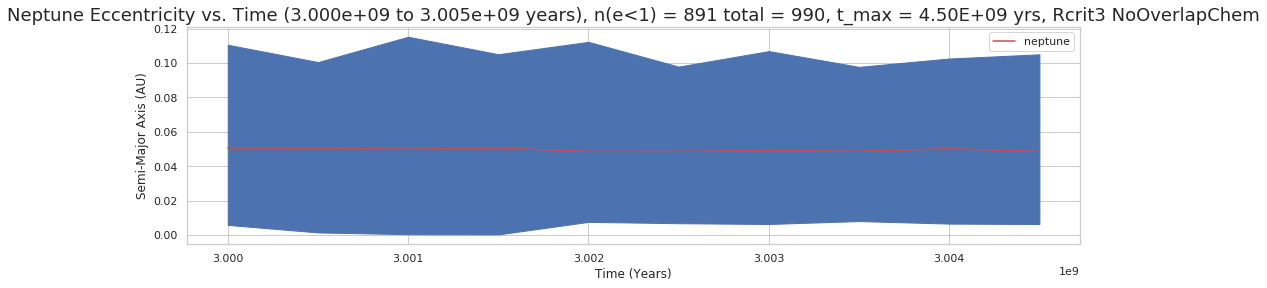

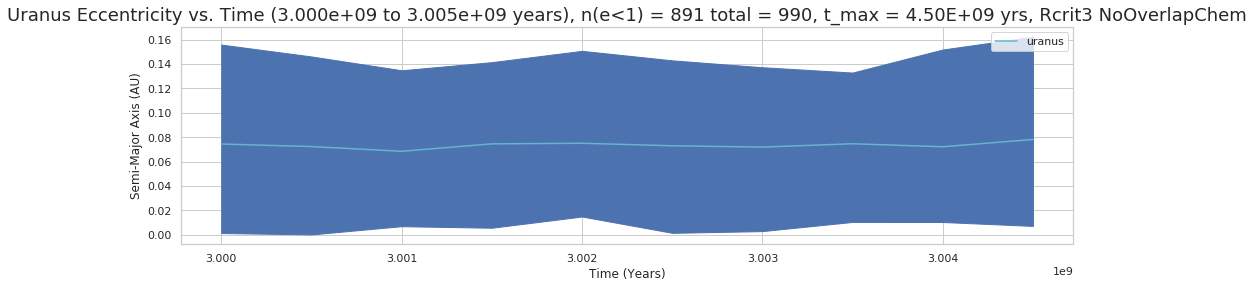

In [22]:
#Plot planet orbits
plot_planets_time(planets_orbits_data, t_list, sim_name_, str(timescale), Rcrit, ChemDist)

In [ ]:
#Plot a vs e animation
HTML(anim.to_html5_video(embed_limit=500))
#HTML(anim.to_jshtml(embed_limit=500))

In [ ]:
anim.save("Semi-major Axis vs. Eccentricity, n(e<1) = "+str((orbits_data[-1]['e'] < 1.).sum())+" total = "+str(comets_total)+", t_max = "+str(timescale)+" yrs "+Rcrit+" "+ChemDist+".mp4")

## Do some statistical analysis

In [ ]:
#Simple pearson and spearman analysis
if ("BinaryChem" in ChemDist) or ("NoOverlapChem" in ChemDist):
    pear_corr_a_CO = orbits_data[-1]["a"].corr(orbits_data[-1]["CO"])
    pear_corr_e_CO = orbits_data[-1]["e"].corr(orbits_data[-1]["CO"])
    
    spear_corr_a_CO = orbits_data[-1]["a"].corr(orbits_data[-1]["CO"], method="spearman")
    spear_corr_e_CO = orbits_data[-1]["e"].corr(orbits_data[-1]["CO"], method="spearman")
    
    print("Pearson Correlation Coefficient (a to CO):",pear_corr_a_CO)
    print("Pearson Correlation Coefficient (e to CO):",pear_corr_e_CO)
    
    print("Spearman Correlation Coefficient (a to CO):",spear_corr_a_CO)
    print("Spearman Correlation Coefficient (e to CO):",spear_corr_e_CO)
    print("")
    
    pear_corr_a_CO2 = orbits_data[-1]["a"].corr(orbits_data[-1]["CO2"])
    pear_corr_e_CO2 = orbits_data[-1]["e"].corr(orbits_data[-1]["CO2"])
    
    spear_corr_a_CO2 = orbits_data[-1]["a"].corr(orbits_data[-1]["CO2"], method="spearman")
    spear_corr_e_CO2 = orbits_data[-1]["e"].corr(orbits_data[-1]["CO2"], method="spearman")
    
    print("Pearson Correlation Coefficient (a to CO2):",pear_corr_a_CO2)
    print("Pearson Correlation Coefficient (e to CO2):",pear_corr_e_CO2)
    
    print("Spearman Correlation Coefficient (a to CO2):",spear_corr_a_CO2)
    print("Spearman Correlation Coefficient (e to CO2):",spear_corr_e_CO2)

elif ("LinearChem" in ChemDist):
    pear_corr_a_chemratio = orbits_data[-1]["a"].corr(orbits_data[-1]["Chem_ratio"])
    pear_corr_e_chemratio = orbits_data[-1]["e"].corr(orbits_data[-1]["Chem_ratio"])
    print("Pearson Correlation Coefficient (a to chemratio):",pear_corr_a_chemratio)
    print("Pearson Correlation Coefficient (e to chemratio):",pear_corr_e_chemratio)
    
    print("Spearman Correlation Coefficient (a to chemratio):",spear_corr_a_chemratio)
    print("Spearman Correlation Coefficient (e to chemratio):",spear_corr_e_chemratio)
